In [1]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import os.path as osp

# Data directories
checkpoints = '/kaggle/working/checkpoint/'
data_root = '/kaggle/input/birds23sp/birds'
training_dir = osp.join(data_root, "train/")
test_dir = osp.join(data_root, "test/")

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create checkpoint directory if not exists
if not osp.exists(checkpoints):
    os.makedirs(checkpoints)


cuda:0


In [1]:
# Maintenance shell commands
# !cd ../input/birds23sp/birds; ls
# !cd /kaggle/working/checkpoint/;ls; rm -rf *.pkl; ls

checkpoint-1.pkl   checkpoint-2.pkl  checkpoint-5.pkl  checkpoint-8.pkl
checkpoint-10.pkl  checkpoint-3.pkl  checkpoint-6.pkl  checkpoint-9.pkl
checkpoint-11.pkl  checkpoint-4.pkl  checkpoint-7.pkl


In [2]:
# Get dataloaders for the bird dataset
# Splits the data under 'training' directory into 80% training and 20% validation (test data)
# The actual test data for the competition comes from the 'test' directory
def get_bird_data():
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
        transforms.ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1),
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    # Load all data
    fullset = torchvision.datasets.ImageFolder(root=training_dir, transform=transform_train)
    fullsetloader = torch.utils.data.DataLoader(fullset, batch_size=64, shuffle=True, num_workers=2)
    
    # Reserve some images in training directory for testing
    # https://stackoverflow.com/a/51768651
    train_size = int(0.8 * len(fullset))  # 80% for training
    test_size = len(fullset) - train_size  # Remaining 20% for testing
    
    trainset, testset = torch.utils.data.random_split(fullset, [train_size, test_size])
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    # Load actual test data
    actual_testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform_test)
    actual_testloader = torch.utils.data.DataLoader(actual_testset, batch_size=1, shuffle=False, num_workers=2)


    classes = open(osp.join(data_root,"names.txt")).read().strip().split("\n")
    class_to_idx = fullset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader,'actual_test':actual_testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

# Print stats about the dataset
print(len(data['to_name']))
print("train size: ", len(data['train'].dataset))
print("test size: ", len(data['test'].dataset))

555
train size:  30849
test size:  7713


torch.Size([8, 3, 128, 128])


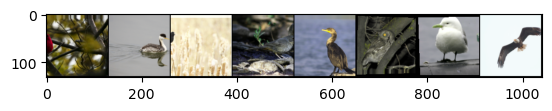

Labels:Scarlet Tanager (Breeding Male), Clark's Grebe, Red-winged Blackbird (Male), Canyon Towhee, Double-crested Cormorant (Immature), Western Screech-Owl, Black-legged Kittiwake (Adult), Bald Eagle (Adult, subadult)


In [3]:
# Show sample image
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [4]:
# Calculate prediction accuracy
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [9]:
# Trains a given network on a supplied dataset
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
        
        if losses[-1] < 2:
            print("Epoch %i / %i"%(epoch, epochs))
            print("Train accuracy: %f"%accuracy(net, data['train']))
            print("Test accuracy: %f"%accuracy(net, data['test']))
    return losses

In [10]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', weights='ResNet34_Weights.DEFAULT')

# Number of feature going into the fully connected layer
last_level_dim = resnet.fc.in_features

# Replace & reinitialize the fully connected layer
resnet.fc = nn.Linear(last_level_dim, 555)


# Optionally resume from a previous checkpoint
cp = osp.join(checkpoints, "checkpoint-5.pkl")
if osp.exists(cp):
    state = torch.load(cp)
else:
    state = None
print("Loading from checkpoint?", state is not None)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Loading from checkpoint? False


In [11]:
# training parameter
#  - learning rate schedule:
#           0.01 for epochs 0-2, 0.001 for epochs 3-4, 0.0001 for epochs 5
#  - weight decay: 0.0005
#  - momentum: 0.9
#  - batch size: 64
#  - epochs: 6
#  - optimizer: SGD
losses = train(resnet, data['train'], epochs=6, lr=.01,schedule={3:0.001, 5:0.0001}, print_every=10, state=state,checkpoint_path=checkpoints)

[0,    10] loss: 6.565
[0,    20] loss: 6.481
[0,    30] loss: 6.346
[0,    40] loss: 6.307
[0,    50] loss: 6.079
[0,    60] loss: 6.030
[0,    70] loss: 5.823
[0,    80] loss: 5.646
[0,    90] loss: 5.552
[0,   100] loss: 5.289
[0,   110] loss: 5.121
[0,   120] loss: 5.075
[0,   130] loss: 4.930
[0,   140] loss: 4.862
[0,   150] loss: 4.814
[0,   160] loss: 4.489
[0,   170] loss: 4.546
[0,   180] loss: 4.453
[0,   190] loss: 4.339
[0,   200] loss: 4.278
[0,   210] loss: 4.160
[0,   220] loss: 4.159
[0,   230] loss: 4.154
[0,   240] loss: 3.972
[0,   250] loss: 4.085
[0,   260] loss: 3.974
[0,   270] loss: 3.897
[0,   280] loss: 3.884
[0,   290] loss: 3.812
[0,   300] loss: 3.846
[0,   310] loss: 3.938
[0,   320] loss: 3.754
[0,   330] loss: 3.618
[0,   340] loss: 3.619
[0,   350] loss: 3.755
[0,   360] loss: 3.481
[0,   370] loss: 3.587
[0,   380] loss: 3.619
[0,   390] loss: 3.611
[0,   400] loss: 3.609
[0,   410] loss: 3.542
[0,   420] loss: 3.386
[0,   430] loss: 3.341
[0,   440] 

Testing  accuracy: 0.715388
Testing  accuracy: 0.538312


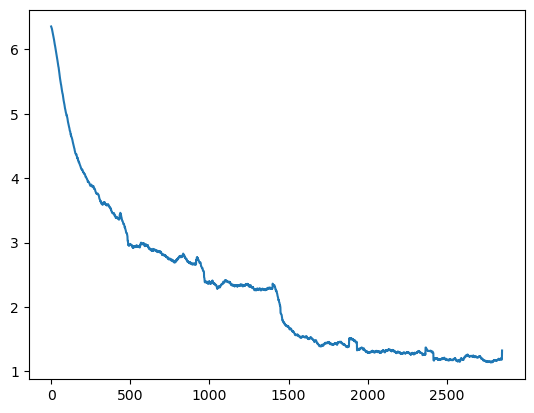

In [12]:
# Restore a previous checkpoint and test its accuracy
# state = torch.load(osp.join(checkpoints, "checkpoint-11.pkl"))

# resnet.load_state_dict(state['net'])
# optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
# optimizer.load_state_dict(state['optimizer'])
# losses = state['losses']
# print("Accuracy: ", accuracy(resnet, data['test']))

# Plot the training loss curve
plt.plot(smooth(losses,50))

# Calculate training & validation accuracy
print("Testing  accuracy: %f" % accuracy(resnet, data['train']))
print("Testing  accuracy: %f" % accuracy(resnet, data['test']))


In [ ]:
# Performs prediction on a dataset and writes the results to a csv file
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

# Predict on the actual test data for the competition
predict(efficientnet, data['actual_test'], "submission.csv")